# Задание №2: Фрактальное сжатие

ФИО: Кириллов Алексей Константинович
Группа: 205

# ИНФОРМАЦИЯ ДЛЯ ЧИТАТЕЛЕЙ
После объявления класса компрессора есть интересные графики

**Баллы за задание выставляются исходя из качества алгоритма по итограм сравнения всех решений**

## Правила сдачи
* Для сдачи необходимо в [cv-gml](https://fall.cv-gml.ru/) загрузить Jupyter-ноутбук с выполненным заданием
* В некоторых ячейках есть строки (`# GRADED CELL: [function name]`), эти строки **менять нельзя**, они будет использоваться при проверке вашего решения
* Интерфейс функций и классов помеченных таким образом должен остаться без изменений
* Ячейка со строкой (`# GRADED CELL: [function name]`) должна содержать только **одну функцию или класс**
 * Лайфхак: функции можно определять внутри функций
* Никакие другие ячейки не будут использованы при проверке, они должны быть самодостаточны
* Запрещено импортировать иные библиотеки и функции, кроме указанных в первой ячейке с кодом  
(если сильно захочется что-то еще импортировать, спросите в чате курса)

## Немного теории
Алгоритм описан в главе про [сжатие изображений](https://compression.ru/book/part2/part2__3.htm#_Toc448152512).

### Определения
**Ранговый блок**: если исходное изображение разбивается на непересекающиеся блоки одинакового размера, замощающие всё изображение, то каждый такой блок называется *ранговым*; имеют меньший размер, чем доменные блоки.

**Доменный блок**: если исходное изображение разбивается блоки одинакового размера, которые могут и пересекаться, то каждый такой блок называется *доменным*; имеют больший размер, чем ранговые блоки.

**Идея алгоритма**:

При сжатии:
1. для каждого рангового блока найти наиболее похожий на него доменный блок (с учётом поворотов и симметрии)
2. выполнить преобразование яркости
3. в качестве сжатого изображения выступают коэффициенты преобразования ранговых блоков, эффективно записанные в файл (строку)

При декомпрессии:
1. Прочитать файл (строку), извлечь коэффициенты преобразований
2. Применить преобразования к исходному изображению (обычно просто серое) пока результат не стабилизируется

In [22]:
# Standard Python Library

import os
import itertools

from collections import namedtuple

# Additional Modules

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv, yuv2rgb

from tqdm import tqdm

import tests

Первым делом нужно загрузить картинку

In [534]:
lenna_rgb_512x512 = io.imread('test_files/lenna.bmp')
lenna_rgb_256x256 = np.rint(resize(lenna_rgb_512x512, (256, 256)) * 255).astype('uint8')
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype('uint8')
baboon_256 = io.imread('test_files/baboon.bmp')
baboon_256 = np.rint(resize(baboon_256, (256, 256)) * 255).astype('uint8')
boats_256 = np.rint(resize(io.imread('test_files/BoatsColor.bmp'), (256, 256)) * 255).astype('uint8')

`plt` — модуль для рисования графиков и всего остального

Очень удобная штука, будем пользоваться ей довольно часто

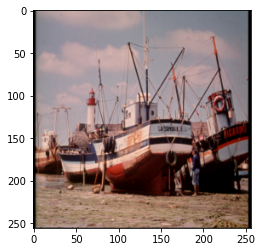

In [24]:
plt.imshow(boats_256, cmap='gray')

## Общие функции
В следующих клетках описаны функции и классы, которые будут использоваться **вами** при выполнении следующих подзаданий. Стоит с ними подробно ознакомиться, понять, что они делают, и поэкспериментировать.

Вы можете свободно эксперементировать с форматом BlockTransform и FractalCompressionParams при необходимости

In [25]:
# GRADED CELL: BlockTransform

BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'col', 'tr', 'mse', 'size', 'x_or', 'y_or'])
ColorChange = namedtuple('ColorChange', ['p', 'r'])

#### BlockTransform

Трансформация, которая приближает данный ранговый блок

* `x, y` Координаты выбранного доменного блока
* `di` Цветовое смещение
* `tr` Закодированное преобразование (поврот и смещение)

In [26]:
# GRADED CELL: FractalCompressionParams

FractalCompressionParams = namedtuple(
    'FractalCompressionParams', [
        'height',
        'width',
        'is_colored',
        'block_size',
        #         'spatial_scale',
        #         'intensity_scale',
        'stride'
    ]
)

In [27]:
def derive_num_bits(length, stride):
    return np.ceil(np.log2(length / stride)).astype(int)

In [28]:
def is_colored(image):
    if len(image.shape) == 2:
        return False
    elif len(image.shape) == 3 and image.shape[-1] == 3:
        return True
    else:
        message = 'Invalid shape of the image: `{}`'
        raise ValueError(message.format(image.shape))

### Функция для нахождения наилучшего преобразования рангового блока

#### Описание

на входе функции подаются:
* исходное Ч/Б изображение (`image`)
* уменьшенное изображение (`resized_image`)
* координаты рангового блока (`x`, `y`)
* размер блока (`block_size`)
* шаг, через сколько пикселей перескакивать при переборе (`stride`)

на выходе функция должна выдавать:
* лучшее преобразование в смысле MSE, объект типа `BlockTransform`

#### Примечания по использованию resized_image

Доменный блок больше рангового, поэтому для сопоставления его нужно уменьшить. Но операция уменьшения дорогая при применении к каждому блоку, поэтому можно сразу уменьшить все изображение целиком и выбирать доменные блоки оттуда.

In [540]:
# GRADED CELL: find_block_transform

def find_block_transform(image, image_2, resized_image, resized_image_2, x, y, block_size, stride, to_print=False):
    '''Find best transformation for given rank block.

    Parameters
    ----------
    image : np.array
        Source B/W image.

    resized_image: np.array
        Resized source image.

    x, y: int, int
        Coordinates of the rank block.

    block_size: int
        Size of rank block.

    stride: int
        Vertical and horizontal stride for domain block search.

    Returns
    -------
    best_transform: BlockTransform
        Best transformation.
    '''

    def find_contrast_params(R, R_2, D, D_2):
        R = R.astype('float32')
        D = D.astype('float32')
        sum_R = np.sum(R)
        sum_D = np.sum(D)
        sum_R2 = np.sum(R_2)
        sum_D2 = np.sum(D_2)
        sum_RD = sum_DR = np.sum(D * R)
        n = R.shape[0]
        n_2 = R.size
        divider = (sum_D2 * n_2 - sum_D ** 2)
        if divider == 0: return 1, 0, 10000000000
        p = (sum_DR * n_2 - sum_D * sum_R) / divider
        if abs(p) > 0.99:
            p = 0.99 if p > 0 else -0.99
        p = int(16 * p) / 16
        r = (sum_R - p * sum_D) / (n ** 2)
        r = round(r / 2) * 2
        MSE = sum_R2 + (p ** 2) * sum_D2 + (n * r) ** 2 - 2 * p * sum_RD - 2 * r * sum_R + 2 * p * r * sum_D
        MSE *= n ** 0.25
        # p = 0.75
        # X = R - D * p
        # r = (np.sum(X)) / D.size
        # r = int(r)
        # MSE = np.sum((X - r)**2)

        return p, r, MSE

    def trans(X, i):
        for j in range(i % 4):
            X = np.rot90(X)
        if (i >= 4):
            X = X.T
        return X

    # resized_image = resized_image * 0.75
    trans_im = [trans(resized_image, i) for i in range(8)]
    trans_im_2 = [trans(resized_image_2, i) for i in range(8)]
    R = image[x:x + block_size, y:y + block_size]
    R_2 = image_2[x:x + block_size, y:y + block_size]
    size = image.shape[0]
    best_t = None
    best_MSE = 10000000000000
    for xx, yy in itertools.product(range(0, size // 2 - block_size + 1, stride),
                                    range(0, size // 2 - block_size + 1, stride)):
        for i in range(8):
            D = trans_im[i][xx:xx + block_size, yy:yy + block_size]
            D_2 = trans_im_2[i][xx:xx + block_size, yy:yy + block_size]
            p, r, MSE = find_contrast_params(R, R_2, D, D_2)
            if MSE < best_MSE:
                best_MSE = MSE
                best_t = BlockTransform(xx, yy, ColorChange(p, r), i, MSE, block_size, x, y)

    if to_print == True:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)

        plt.subplot(1, 3, 2)
        plt.imshow(R, cmap='gray', vmin=0, vmax=255)

        t = best_t
        xx = t.x;
        yy = t.y;
        p = t.col.p;
        r = t.col.r
        # coords on source image
        D = trans_im[t.tr][xx:xx + block_size, yy:yy + block_size]
        X = D * p + r
        plt.subplot(1, 3, 3)
        plt.imshow(X, cmap='gray', vmin=0, vmax=255)
    return best_t

### Несколько отладочных тестов

BlockTransform(x=0, y=0, col=ColorChange(p=0.9375, r=4), tr=2, mse=12455.2734375, size=15, x_or=0, y_or=0)


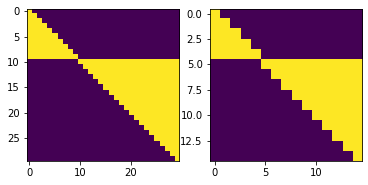

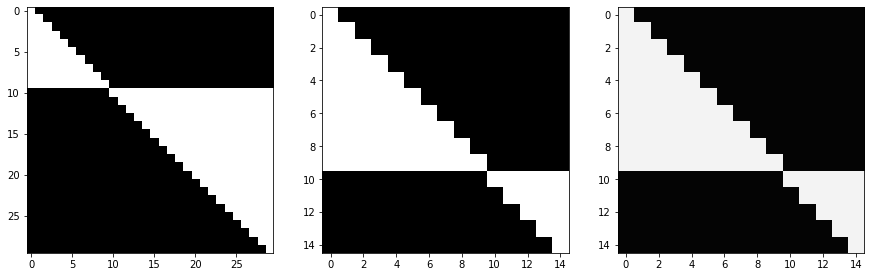

In [62]:
a = np.zeros((30, 30), dtype='float64')
a[0:10, 0:10] = np.tril(np.ones((10, 10)), 0)
a[10:30, 10:30] = np.tril(np.ones((20, 20)), 0).T
b = np.zeros((15, 15), dtype='float64')
b[0:5, 0:5] = np.tril(np.ones((5, 5)))
b[5:15, 5:15] = np.tril(np.ones((10, 10))).T
a *= 255;
b *= 255

plt.subplot(1, 2, 1)
plt.imshow(a)
plt.subplot(1, 2, 2)
plt.imshow(b)

t1 = find_block_transform(a, a ** 2, b, b ** 2, 0, 0, 15, 1, True)
print(t1)

13.0 252.0625
BlockTransform(x=0, y=5, col=ColorChange(p=0.9375, r=13), tr=7, mse=3428.828125, size=10, x_or=0, y_or=0)


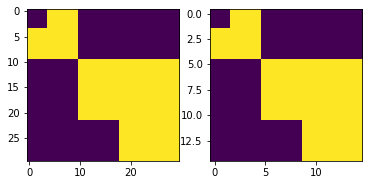

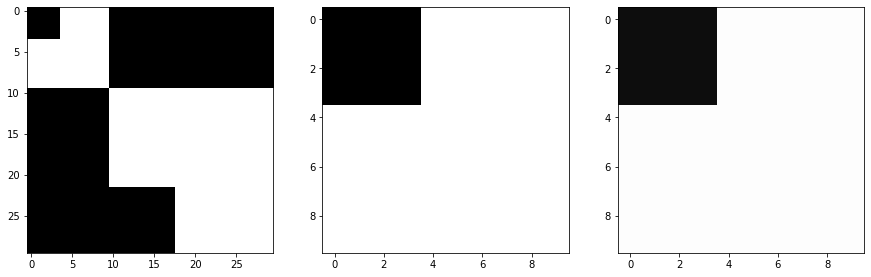

In [31]:
a = np.zeros((30, 30), dtype=float)
a[0:10, 0:10] = np.ones((10, 10))
a[0:4, 0:4] = np.zeros((4, 4))
a[10:30, 10:30] = np.ones((20, 20))
a[22:30, 10:18] = np.zeros((8, 8))

a *= 255
b = np.zeros((15, 15), dtype=float)
b[0:5, 0:5] = np.ones((5, 5))
b[0:2, 0:2] = np.zeros(())
b[5:15, 5:15] = np.ones((10, 10))
b[11:15, 5:9] = np.zeros((4, 4))
b *= 255

plt.subplot(1, 2, 1)
plt.imshow(a)
plt.subplot(1, 2, 2)
plt.imshow(b)

t1 = find_block_transform(a, a ** 2, b, b ** 2, 0, 0, 10, 1, True)
print(t1)

### Применение IFS к изображению

#### Описание

на входе функции подаются:
* исходное изображение (`image`)
* уменьшенное изображение (`resized_image`)
* IFS, массив объектов типа `BlockTransform` (`transforms`)
* размер блока (`block_size`)

на выходе функция должна выдавать:
* картинку после одинарного применения IFS

In [32]:
# GRADED CELL: perform_transform

def perform_transform(image, resized_image, transforms, block_size):
    '''Perform IFS on given image.
    
    Parameters
    ----------
    image : np.array
        Source image.

    resized_image: np.array
        Resized source image.

    transforms: list of BlockTransform's
        Given IFS, Iterated Function System
    
    block_size: int
        Size of rank block.

    Returns
    -------
    transformed_image: np.array
        Transformed image.
    '''

    def trans(X, i):
        for j in range(i % 4):
            X = np.rot90(X)
        if (i >= 4):
            X = X.T
        return X

    class Reader:
        def __init__(self, t):
            self.pos = 0
            self.body = t

        def read(self):
            ret = self.body[self.pos]
            self.pos += 1
            return ret

    def decode_block(x, y, block_size):
        elem = rdr.read()
        if elem != 'split':
            xx = elem.x;
            yy = elem.y;
            p = elem.col.p;
            r = elem.col.r  # coords on source image
            D = trans_im[elem.tr][xx:xx + block_size, yy:yy + block_size]
            X = D * p + r
            transformed_image[x:x + block_size, y:y + block_size] = X
        else:
            block_size //= 2
            decode_block(x, y, block_size)
            decode_block(x + block_size, y, block_size)
            decode_block(x, y + block_size, block_size)
            decode_block(x + block_size, y + block_size, block_size)

    image_size = image.shape[0]
    # resized_image = resized_image * 0.75
    transformed_image = np.zeros(image.shape)
    rdr = Reader(transforms)

    trans_im = [trans(resized_image, i) for i in range(8)]
    coordinates = itertools.product(range(0, image_size, block_size), range(0, image_size, block_size))
    for x, y in coordinates:
        decode_block(x, y, block_size)
    return transformed_image

### Тестирование функций нахождения наилучшего преобразования и применения IFS к изображению

#### Описание

* Эти тесты нужны только для базовой отладки двух функций выше, они не используются при оценке задания
* Тесты проверяют правильность подбора di и возможность использования поворотов и отражений
* Если тесты не проходят, возможно вы реализовали неоптимальный алгоритм поиска преобразований
* Даже с неоптимальным поиском блоков можно успешно сжать и расжать изображение

In [33]:
# tests.test_transform(find_block_transform, perform_transform)

### Класс, реализующий интерфейс битового массива
Он понадобится для преобразования найденной IFS в строку, чтобы записать сжатый файл на диск.

In [34]:
# GRADED CELL: BitBuffer

class BitBuffer:
    '''Class that provides storing and and reading integer numbers
    in continuous bytearray.

    Parameters
    ----------
    buffer : bytearray, optional (default=None)
        Input bytearray, for initialization.

    Attributes
    ----------
    _buffer : bytearray
        Bytearray that can contain any information.

    Examples
    --------
    >>> buffer = BitBuffer()
    >>> buffer.push(1, 1)
    >>> x = buffer.pop(1)
    >>> print(x)
    1
    >>> buffer.push(125, 18)
    >>> x = buffer.pop(18)
    >>> print(x)
    125
    >>> buffer.push(5, 3)
    >>> x = buffer.pop(3)
    >>> print(x)
    5

    >>> dy = transform.y // stride
    >>> buffer.push(dy, self._num_bits_ver)
    '''

    def __init__(self, buffer=None):
        self.chunk = 8
        if buffer is not None:
            self.from_raw(buffer)
        else:
            self.rescale = 1
            self.pos = 0
            self.size = self.chunk * self.rescale
            self.body = np.zeros(self.rescale, dtype=np.int8)

    def to_bytearray(self):
        '''Convert to bytearray.

        Returns
        -------
        buffer: bytearray
            Bytearray that contains all data.
        '''
        cur_pos = self.pos % 8
        self.push(0, 8 - cur_pos)
        self.push(0, 5)
        self.push(cur_pos, 3)
        return bytearray(self.body)

    def from_raw(self, buf):
        self.body = np.array(buf)
        self.pos = self.body.size * self.chunk
        self.size = self.pos
        cur_pos = self.pop(3)
        self.pop(5)
        self.pop(8 - cur_pos)

    def push(self, x, n_bits):
        '''Push given integer to buffer.

        Parameters
        ----------
        x : int
            Input number.

        n_bits: int
            Number of bits for store input number,
            should be greater than log2(x).
        '''

        # YOUR CODE HERE
        while self.pos + n_bits > self.size:
            self.body = np.concatenate((self.body, np.zeros(self.rescale, dtype=np.int8)))
            self.size += self.rescale * self.chunk
        for i in range(self.pos, self.pos + n_bits):
            bit = (x % 2) << (i % self.chunk)
            self.body[i // self.chunk] |= bit
            x >>= 1
        self.pos += n_bits

    def pop(self, n_bits):
        '''Pop n_bits from buffer and transform it to a number.

        Parameters
        ----------
        n_bits: int
            Number of bits for pop from buffer.

        Returns
        -------
        x: int
            Extracted number.
        '''

        # YOUR CODE HERE
        x = 0
        for i in range(self.pos - 1, self.pos - n_bits - 1, -1):
            x <<= 1
            bias = i % self.chunk
            bit = 1 << bias
            x += (self.body[i // self.chunk] & bit) >> bias
            self.body[i // self.chunk] &= ~np.int8(bit)
        self.pos -= n_bits
        return x

### Тестирование битового массива

#### Описание

* Эти тесты нужны только для базовой отладки класса выше, они не используются при оценке задания
* Тесты проверяют корректность записи и чтения в FIFO либо LIFO формате. Вы можете использовать любой из них

In [35]:
tests.test_bit_buffer(BitBuffer)

'OK'

### Класс, реализующий интерфейс архиватора изображений

#### Условие
* Класс будет тестироваться как на черно-белых, так и на **цветных** изображениях
* Для цветных изображений необходимо переходить в YUV, сжимать, а потом обратно в RGB для финального результата
* В качестве оценки алгоритма будет использоваться кривая размер-качество, построенная на основе запуска метода compress2, с параметрами качества [0, 20, 40, 60, 80, 100]
* Следует обеспечить непрерывную монотонную зависимость реального качества декодированного изображения от параметра качества
* Баллы будут выставляться исходя из того, насколько построенный график размер-качество лежит близко к верхнему левому углу (высокое качество и низкий размер)
* За красивые графики с равномерно распределенными узлами [0 ... 100] и без точек перегиба выставляются дополнительные баллы
* Ограничение времени работы (суммарно сжатие и разжатие) на всех уровнях качества: 5 минут

**Интерфейсом данного класса считаются только методы compress2 и decompress, остальные можно менять как угодно**`

In [572]:
# GRADED CELL: FractalCompressor

class Node:
    def __init__(self, t=None, x=0, y=0, size=4):
        self.childs = [None] * 4
        self.t = t
        self.x = x
        self.y = y
        self.size = size
        self.split = False

    def divide(self):
        self.split = True
        vals = {0: {'x': self.x, 'y': self.y, 'size': self.size // 2},
                1: {'x': self.x + self.size // 2, 'y': self.y, 'size': self.size // 2},
                2: {'x': self.x, 'y': self.y + self.size // 2, 'size': self.size // 2},
                3: {'x': self.x + self.size // 2, 'y': self.y + self.size // 2, 'size': self.size // 2},
                }
        for i in range(4):
            self.childs[i] = Node(**vals[i])

    def flatten(self, node=None):
        res = []
        node = node or self
        if node.split == 1:
            res.append('split')
            for i in range(4):
                res += self.flatten(node.childs[i])
        else:
            res.append(node.t)
        return res

    def print(self, b=0):
        node = self
        print('\t' * b + f"[{node.x} {node.y} {node.size}] = {b}")
        for node in self.childs:
            if node:
                node.print(b + 1)


class MaxHeap:
    def __init__(self, maxsize):
        # 'x', 'y', 'col', 'tr', 'mse', 'size', 'x_or', 'y_or'

        self.maxsize = maxsize
        self.size = 0
        self.Heap = [Node(t=BlockTransform(-1, -1, ColorChange(-1, -1), -1, -1, -1, -1, -1))] * (self.maxsize + 1)
        self.Heap[0] = Node(t=BlockTransform(-1, -1, ColorChange(-1, -1), -1, 10000000000000, -1, -1, -1))
        self.FRONT = 1

    def parent(self, pos):
        return pos // 2

    def leftChild(self, pos):
        return 2 * pos

    def rightChild(self, pos):
        return (2 * pos) + 1

    def isLeaf(self, pos):
        if (self.size // 2) <= pos <= self.size:
            return True
        return False

    def swap(self, fpos, spos):
        self.Heap[fpos], self.Heap[spos] = (self.Heap[spos],
                                            self.Heap[fpos])

    def val(self, elem: Node):
        return elem.t.mse

    def maxHeapify(self, pos):
        if not self.isLeaf(pos):
            if (self.val(self.Heap[pos]) < self.val(self.Heap[self.leftChild(pos)]) or
                    self.val(self.Heap[pos]) < self.val(self.Heap[self.rightChild(pos)])):
                if (self.val(self.Heap[self.leftChild(pos)]) >
                        self.val(self.Heap[self.rightChild(pos)])):
                    self.swap(pos, self.leftChild(pos))
                    self.maxHeapify(self.leftChild(pos))
                else:
                    self.swap(pos, self.rightChild(pos))
                    self.maxHeapify(self.rightChild(pos))

    def insert(self, element: Node):
        if self.size >= self.maxsize:
            print('exceeded max heap size')
            return
        self.size += 1
        self.Heap[self.size] = element
        current = self.size
        while (self.val(self.Heap[current]) >
               self.val(self.Heap[self.parent(current)])):
            self.swap(current, self.parent(current))
            current = self.parent(current)

    def print(self):
        for i in range(1, (self.size // 2) + 1):
            print(" PARENT : " + str(self.Heap[i].t) +
                  " LEFT CHILD : " + str(self.Heap[2 * i].t) +
                  " RIGHT CHILD : " + str(self.Heap[2 * i + 1].t))

    def pop(self):
        popped = self.Heap[self.FRONT]
        self.Heap[self.FRONT] = self.Heap[self.size]
        self.size -= 1
        self.maxHeapify(self.FRONT)
        return popped


class FractalCompressor:
    '''Class that performs fractal compression/decompression of images.

    Attributes
    ----------
    _num_bits_ver : int
        Number of bits for store VERTICAL OFFSET for each transformation.

    _num_bits_hor : int
        Number of bits for store HORIZONTAL OFFSET for each transformation.

    _num_bits_pix : int
        Number of bits for store INTENSITY OFFSET for each transformation.

    _num_bits_tfm : int
        Number of bits for store TRANFORMATION INDEX for each transformation.

    Examples
    --------
    >>> comp = FractalCompressor()
    >>> compressed_image = comp.compress(image, block_size=8, stride=2)
    >>> decompressed_image = comp.decompress(compressed_image, num_iters=9)
    >>> yet_another_compressed_image = comp.compress(image, 8, 4, 0.5, 0.7)
    >>> yet_another_decompressed_image = comp.compress(yet_another_compressed_image, 5)
    '''

    def __init__(self):
        #         self._num_bits_ver = None
        #         self._num_bits_hor = None
        #         self._num_bits_pix = derive_num_bits( # YOUR CODE HERE )
        #         self._num_bits_tfm = derive_num_bits( # YOUR CODE HERE )
        pass

    def _add_header(self, buffer, params):
        '''Store header in buffer.

        Parameters
        ----------
        buffer: BitBuffer

        params: FractalCompressionParams
            Parameters that should be stored in buffer.

        Note
        ----
        This method must be consistent with `_read_header`.
        '''

        #         FractalCompressionParams = namedtuple(
        #             'FractalCompressionParams', [
        #                 'height',
        #                 'width',
        #                 'is_colored',
        #                 'block_size',
        #                / 'spatial_scale',
        #                / 'intensity_scale',
        #                 'stride'
        #             ]
        #         )
        # YOUR CODE HERE

        buffer.push(params.height, 16)
        buffer.push(params.width, 16)
        buffer.push(params.is_colored, 1)
        buffer.push(params.block_size, 8)
        #         buffer.push(params.spatial_scale)
        #         buffer.push(intensity_scale)
        buffer.push(params.stride, 8)

    def _read_header(self, buffer):
        '''Read header from buffer.

        Parameters
        ----------
        buffer: BitiBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted parameters.

        Note
        ----
        This method must be consistent with `_add_header`.
        '''

        # YOUR CODE HERE
        stride = buffer.pop(8)
        intensity_scale = 0.75
        spatial_scale = 0.5
        block_size = buffer.pop(8)
        is_colored = buffer.pop(1)
        width = buffer.pop(16)
        height = buffer.pop(16)

        params = FractalCompressionParams(height, width, is_colored, block_size, stride)
        return params

    def _add_transform(self, buffer, transform, stride):
        '''Store block transformation in buffer.

        Parameters
        ----------
        buffer: BitBuffer

        transform: BlockTransform

        stride: int
            Vertical and horizontal stride for domain block search.

        Note
        ----
        This method must be consistent with `_read_transform`.
        '''

        if transform == 'split':
            buffer.push(0, 1)
            buffer.push(1, 1)
        else:
            buffer.push(transform.x // 16, 3)
            buffer.push(transform.y // 16, 3)
            buffer.push(int(16 * transform.col.p) + 16, 5)
            r = transform.col.r
            abs_r = abs(r);
            sign_r = 1 if r > 0 else 0
            not_char = 1 if abs(r) > 255 else 0
            buffer.push(abs_r // 2, 7)
            buffer.push(not_char, 1)
            buffer.push(sign_r, 1)
            buffer.push(transform.tr, 3)
            buffer.push(0, 1)

    def _read_transform(self, buffer, stride):
        '''Read block transformation from buffer.

        Parameters
        ----------
        buffer: BitBuffer


        stride: int
            Vertical and horizontal stride for domain block search.

        Returns
        -------
        transform: BlockTransform
            Extracted block transformation.

        Note
        ----
        This method must be consistent with `_add_to_buffer`.
        '''

        bit = buffer.pop(1)
        if bit == 0:
            tr = buffer.pop(3)
            sign_r = buffer.pop(1) * 2 - 1
            not_char = buffer.pop(1)
            abs_r = buffer.pop(7) * 2
            r = sign_r * (256 * not_char + abs_r)
            p = 0.75
            p = (buffer.pop(5) - 16) / 16
            y = buffer.pop(3) * 16
            x = buffer.pop(3) * 16

            transform = BlockTransform(x, y, ColorChange(p, r), tr, -1, -1, -1, -1)
        elif bit == 1:
            bit = buffer.pop(1)
            if bit == 0:
                transform = 'split'
            elif bit == 1:
                transform = 'end'
        return transform

    def _read_layer(self, buffer, stride):
        trans = []
        while True:
            t = self._read_transform(buffer, stride)
            if t != 'end':
                trans.append(t)
            elif t == 'end':
                return trans

    def _ifs2buf(self, params, transformations):
        '''Store compression parameters and IFS in buffer.

        Parameters
        ----------
        params: FractalCompressionParams
            Parameters of the compression.

        transformations: list of BlockTransform's
            Given IFS.

        Returns
        -------
        buffer: BitBuffer

        Note
        ----
        This method must be consistent with `_buf2ifs`.
        '''

        buffer = BitBuffer()
        for t_ch in transformations[::-1]:
            buffer.push(1, 1)  # b11
            buffer.push(1, 1)
            for t in t_ch[::-1]:
                self._add_transform(buffer, t, params.stride)
        self._add_header(buffer, params)
        return buffer.to_bytearray()

    def _buf2ifs(self, buffer):
        '''Store compression parameters and IFS in buffer.

        Parameters
        ----------
        buffer: BitBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted compression parameters.

        transforms: list of BlockTransform's
            Extracted IFS.

        Note
        ----
        This method must be consistent with `_ifs2buf`.
        '''

        params = self._read_header(buffer)

        #         self._num_bits_ver = derive_num_bits(params.height, params.stride)
        #         self._num_bits_hor = derive_num_bits(params.width, params.stride)
        #         num_transforms = int(params.height * params.width / params.block_size ** 2)
        n_ch = 3 if params.is_colored else 1
        transforms = [
            self._read_layer(buffer, params.stride)
            for _ in range(n_ch)
        ]

        return params, transforms

    def compress2(self, image, quality= 40):
        n_div = range(100, 1000 + 1, 180)
        params = {q: d for q, d in zip(range(0, 100 + 1, 20), n_div)}
        return self.compress(image, n_div = params[quality])

    def compress(self, image, block_size=16, stride=16, spatial_scale=0.5, intensity_scale=0.75,
                 threshold=1000, min_block=4, n_div=100):
        params = FractalCompressionParams(image.shape[0], image.shape[1], is_colored(image),
                                          block_size, stride)

        def encode(image, image_2, resized_image, resized_image_2, n_div):
            tree = Node(t=BlockTransform(-1, -1, ColorChange(-1, -1), -1, 1, -1, -1, -1), x=0, y=0, size=256)
            heap = MaxHeap(n_div * 5 + 3)
            heap.insert(tree)
            stride = {32: 16, 16: 16, 8: 16, 4: 16, 2: 32}
            for i in tqdm(range(n_div)):
                node = heap.pop()
                node.divide()
                for child in node.childs:
                    # print(child.x, child.y, child.size)
                    t = find_block_transform(
                        image, image_2, resized_image, resized_image_2,
                        child.x, child.y, child.size, stride.get(child.size, 16)
                    )
                    # print(t)
                    child.t = t
                    heap.insert(child)

            trans = tree.flatten()
            return trans

        im = image.astype('float32')
        rim = np.rint(resize(im, (128, 128))).astype('float32')
        if is_colored(im):
            im = (rgb2yuv(im))
            rim = (rgb2yuv(rim))
            im_channels = [im[:, :, i] for i in range(3)]
            rim_channels = [rim[:, :, i] for i in range(3)]

            t1 = encode(im_channels[0], im_channels[0] ** 2, rim_channels[0], rim_channels[0] ** 2,
                        n_div)
            t2 = encode(im_channels[1], im_channels[1] ** 2, rim_channels[0], rim_channels[0] ** 2,
                        n_div // 8)
            t3 = encode(im_channels[2], im_channels[2] ** 2, rim_channels[0], rim_channels[0] ** 2,
                        n_div // 8)
            # return self._ifs2buf(params, [t1, t2, t3]), (params, [t1, t2, t3])
            return self._ifs2buf(params, [t1, t2, t3])


    def decompress(self, byte_array, num_iters=10):
        params, t = self._buf2ifs(BitBuffer(byte_array))
        if params.is_colored:
            im_channels = [np.ones((256, 256)).astype('float32') * 128 for _ in range(3)]
            rim_channels = [np.zeros((128, 128)).astype('float32') * 128 for _ in range(3)]
            for n_ch in [0]:
                for i in range(num_iters):
                    im_channels[n_ch] = perform_transform(im_channels[n_ch], rim_channels[n_ch], t[n_ch],
                                                          params.height)
                    rim_channels[n_ch] = resize(im_channels[n_ch], (128, 128))
            for n_ch in [1, 2]:
                im_channels[n_ch] = perform_transform(im_channels[0], rim_channels[0], t[n_ch], params.height)
            image = np.dstack(tuple(im_channels[i] for i in range(3)))
            image = yuv2rgb(image)
            for i in range(256):
                for j in range(256):
                    for k in range(3):
                        if image[i][j][k] < 0:
                            image[i][j][k] = 0
                        elif image[i][j][k] > 255:
                            image[i][j][k] = 255
            return np.rint(image).astype('uint8')
        else:
            t = t[0]
            image = np.zeros((params.height, params.width))
            resized_image = resize(image, (params.height // 2, params.width // 2))
            for i in range(num_iters):
                image = perform_transform(image, resized_image, t, params.block_size)
                resized_image = resize(image, (params.height // 2, params.width // 2))
        return image

## Пробуем применить FractalCompressor

In [251]:
# код для оценки качества сжатия
my_last = [[2306, 2667, 3443, 5677, 6934, 9221],
           [27.877692105590615, 28.284977524020935, 29.20103287751554, 30.658915131949517, 31.07957612047426,
            31.536266143370028]]
my_best_prev = [[1798, 1999, 2480, 3109, 3336, 8138],
                [27.33458523997201, 27.586055686911845, 28.323566270171114, 29.12581011417436, 29.52448405621779,
                 31.98309862075915]]
maxim = [[2434, 7234, 11944, 16600, 21074, 25468], [28.62, 32.35, 34.50, 35.92, 37.17, 38.29]]
my_best = [[1164, 3255, 5327, 7417, 9489, 11580],
           [27.050400047471197, 30.4208547604328, 32.38796404672407, 33.93646117870599, 35.13590137332004,
            36.151667981743785]]


def weighted_psnr(ref, img):
    assert ref.shape == img.shape, "Shape mismatch"
    if is_colored(img):
        ref_yuv = rgb2yuv(ref)
        img_yuv = rgb2yuv(img)

        return (4 * psnr(ref_yuv[..., 0], img_yuv[..., 0]) +
                psnr(ref_yuv[..., 1], img_yuv[..., 1]) +
                psnr(ref_yuv[..., 2], img_yuv[..., 2])
                ) / 6
    else:
        return psnr(ref, img)

100%|██████████| 12/12 [00:02<00:00,  4.08it/s]


psnr: 27.050400047471197;	size: 1164


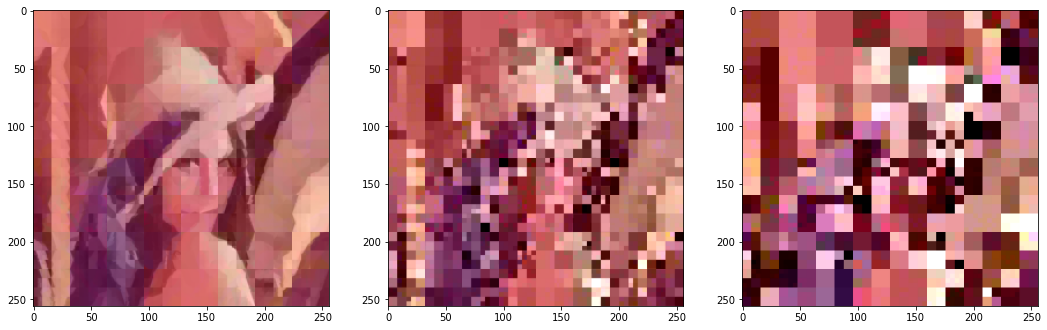

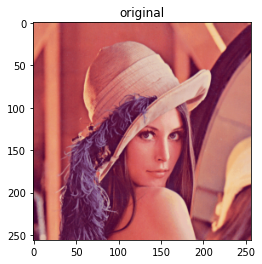

In [573]:
# =============================== testing code ====================================
comp = FractalCompressor()
result = comp.compress2(lenna_rgb_256x256, quality=0)
n_iters = [10, 2, 1]
imgs = [comp.decompress(result, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

print(f'psnr: {weighted_psnr(lenna_rgb_256x256, imgs[0])};\tsize: {len(result)}')
plt.show()
plt.figure(figsize=(4, 4))
plt.title("original")
plt.imshow(lenna_rgb_256x256, cmap='gray')
plt.show()
point = (weighted_psnr(lenna_rgb_256x256, imgs[0]), len(result))

# Статистика
## Как изменяется mse блока после разбиения?

[[124859053.875, 1, 124859053.875], [0.7429471189811796, 17553143.75, 13041057.578125], [0.24947558961664618, 2545030.890625, 634923.08203125], [0.44972086137956224, 322331.58984375, 144959.240234375], [0.44795667112475474, 3579402.5, 1603417.228515625], [0.14884840845529637, 392869.416015625, 58477.9873046875], [0.1696147046995533, 397315.6875, 67390.5830078125], [0.3824887207873412, 625653.15625, 239305.275390625], [0.4476179157544814, 187578.96875, 83963.70703125], [0.36968287213013107, 1585321.1875, 586066.08984375], [0.30817528883531237, 285935.87890625, 88118.3720703125], [0.5116515444840595, 5331303.0, 2727769.4140625], [0.4714870697250052, 259158.6171875, 122189.93701171875], [0.48169792412036516, 1049141.84375, 505369.4482421875], [0.619311586597282, 228366.2265625, 141429.85009765625], [0.5401350134954758, 395028.21875, 213368.572265625], [0.4613000762367186, 1024440.734375, 472574.5888671875], [0.6093315186015814, 187714.267578125, 114380.2197265625], [0.7903165055389801, 31

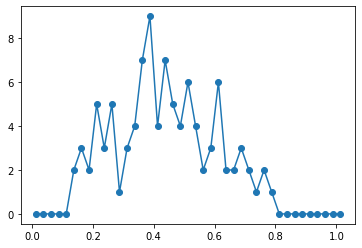

In [542]:
dim = comp.decompress(result)
def mse_block(x, y, s):
    return np.sum((dim[x:x+s, y:y+s] - lenna_rgb_256x256[x:x+s, y:y+s]) ** 2) / (s ** 2)
def fun(node, vals):
    if node.split == 1:
        prev_mse = node.t.mse
        new_mse = 0
        for node2 in node.childs:
            addon = node2.t.mse
            new_mse += addon
        new_mse
        vals.append([new_mse / prev_mse, prev_mse, new_mse])
        for child in node.childs:
            fun(child, vals)

vals = []
fun(tree, vals)
print(vals)

step = 0.025
r = np.arange(0, 1 + step, step)
stat = {a + step / 2: 0 for a in r}
for v in vals:
    for a in r:
        if a < v[0] <= a + step:
            stat[a + step / 2] += 1
plt.plot(stat.keys(), stat.values(), marker = 'o')
plt.show()

В среднем уменьшается в 0.4 раза

## Какие размеры у блоков?

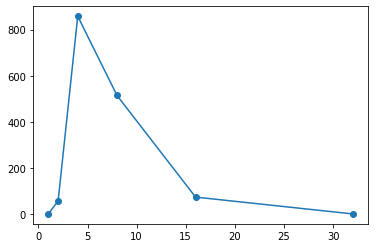

In [193]:
vals = {2 ** x: 0 for x in range(6)}
for t in orig[1][0]:
    if type(t) == BlockTransform:
        vals[t.size] += 1
plt.plot([*vals.keys()], [*vals.values()], marker='o')
plt.show()

$$-$$ произведено ровно 200 делений

Коэффициенты при изображении (статистика для меня)
* 100: 1/0.5/0.5 => 28.36 / 2697
* 100: 1/0.25/0.25 => 27.37 / 2028
* 1000: 1/0.5/0.5 => 36.94 / 20000
* 500: 1/0.25/0.25 => 33.43, 100053; stride = 16, time = 1:30

Посмотрим, как зависит график от параметра alpha, где alpha это параметр в формуле для значения ошибки конкретного блога, вычисляемой по формуле

\begin{equation}mse = \text{[удельная mse]} \cdot block\_size^{alpha} \end{equation}

Это поможет с выбором $alpha$

  1%|          | 3/280 [00:00<00:15, 17.64it/s]

[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.  ]


  1%|          | 2/280 [00:00<00:14, 19.05it/s]

0.25 29.127191186943993 3255


  1%|          | 3/280 [00:00<00:17, 15.46it/s]

0.5 29.545421967997964 3255


  1%|          | 2/280 [00:00<00:13, 19.99it/s]

0.75 29.86416953601808 3255


  1%|          | 2/280 [00:00<00:18, 15.27it/s]

1.0 30.14549978113728 3255


  1%|          | 2/280 [00:00<00:14, 19.79it/s]

1.25 30.376628473333493 3255


  1%|          | 2/280 [00:00<00:16, 16.95it/s]

1.5 30.418150527247032 3255


  0%|          | 0/280 [00:00<?, ?it/s]

1.75 30.41794781369049 3255


  1%|          | 2/280 [00:00<00:14, 19.41it/s]

2.0 30.4208547604328 3255


  1%|          | 2/280 [00:00<00:21, 13.16it/s]

2.25 30.432287933388917 3255


  1%|          | 2/280 [00:00<00:21, 13.16it/s]

2.5 30.41095006793567 3255


100%|██████████| 35/35 [00:08<00:00,  3.95it/s]


2.75 30.413369911587395 3255


100%|██████████| 35/35 [00:08<00:00,  4.22it/s]


3.0 30.36478598718207 3255


Text(0, 0.5, 'PSNR, dB')

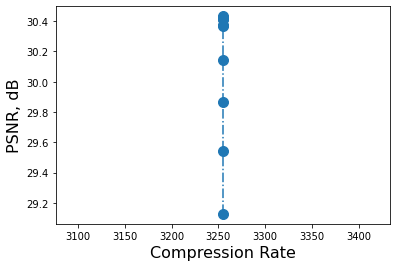

In [272]:
comp = FractalCompressor()
alpha_vals = [1, 2, 3]
print(alpha_vals)
ps = []
cs = []
origs = []
for alpha in alpha_vals:
    comp_im, orig = comp.compress2(lenna_rgb_256x256, 20, alpha)
    dec_im = comp.decompress(comp_im)
    ps_n = weighted_psnr(lenna_rgb_256x256, dec_im)
    cs_n = len(comp_im)
    origs.append(orig)
    ps.append(ps_n)
    cs.append(cs_n)
    print(alpha, ps_n, cs_n)
plt.plot(cs, ps, marker='o', ms=10, ls='-.')
plt.xlabel('Compression Rate', fontsize=16)
plt.ylabel('PSNR, dB', fontsize=16)

Получается, лучше брать большие alpha. Мой выбор пал на alpha = 2

Теперь посмотрим, какие блоки используются чаще других при построении изображения. Для каждого участка изображения посчитаем сколько трансформаций его задействует. На основе полученных результатов будем думать, как сбалансирвоать квадрадерео.

In [ ]:
comp = FractalCompressor()  # тут модифицируем класс таким образом, чтобы он только рисовал графики
result = comp.compress2(lenna_rgb_256x256, quality=40)

оригинал для сравнения:

In [ ]:
plt.imshow(lenna_rgb_256x256)
plt.show()

Видно, что волосы и лицо девшуки вообще не используются

Дальше построим статистику того, какие значения p чаще всего встречаются

100%|██████████| 57/57 [00:10<00:00,  5.47it/s]


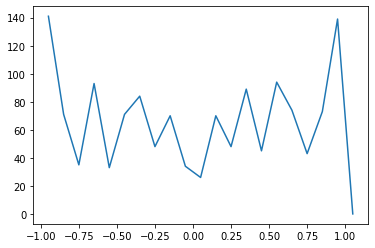

In [241]:
comp = FractalCompressor()
result = comp.compress2(lenna_rgb_256x256, quality=40)
vals = [x.col.p for x in comp._buf2ifs(BitBuffer(result))[1][0] if type(x) == BlockTransform]
step = 0.1
r = np.arange(-1, 1 + step, step)
stat = {a + step / 2: 0 for a in r}
for v in vals:
    for a in r:
        if a < v <= a + step:
            stat[a + step / 2] += 1
plt.plot(stat.keys(), stat.values())
plt.show()

In [243]:
print(len(result), weighted_psnr(lenna_rgb_256x256, comp.decompress(result)))

5327 32.38796404672407


почему-то очень часто используются значения "на концах", близкие по модулю к 1

## Построим график качества
Качество в данном случае будет измеряться по PSNR (а значит в децибелах).

Это базовый график для понимания соотношения между коэффициентом сжатия и качеством, получаемым на выходе. Можно посмотреть, как он будет меняться в зависимости от количества итераций при декомпрессии, например.

In [223]:
quality = [0, 20, 40, 60, 80, 100]


def test_image(img):
    compressed_images = [comp.compress2(img, quality=q)[0] for q in quality]
    decompressed_images = [comp.decompress(compressed) for compressed in compressed_images]
    compression_rates = np.array([len(compressed) for compressed in compressed_images])
    psnrs = [weighted_psnr(img, decompressed) for decompressed in decompressed_images]
    print(compression_rates, psnrs)
    return compression_rates, psnrs, compressed_images

In [209]:
def test_and_plot_collection(collection):
    _, ax = plt.subplots(figsize=(8, 6))

    out = []
    for image in collection:
        compression_rates, psnrs, ci = test_image(image)
        out.append([compression_rates, psnrs, ci])
        ax.plot(compression_rates, psnrs, marker='o', ms=10, ls='-.')

    ax.set_xlabel('Compression Rate', fontsize=16)
    ax.set_ylabel('PSNR, dB', fontsize=16)

    plt.show()

    n = len(out[0][2])
    im_size = 3
    plt.figure(figsize=(2 * im_size, n * im_size))
    for i in range(n):
        plt.subplot(n, 2, 2 * i + 1)
        plt.title(f"{compression_rates[i]}")
        plt.imshow(comp.decompress(out[0][2][i], num_iters=1))
        plt.subplot(n, 2, 2 * i + 2)
        plt.title(f"{psnrs[i]}")
        plt.imshow(comp.decompress(out[0][2][i]))
    plt.show()
    return out

Следующие ячейки - это графики построенные с разными параметрами, с разными идеями, с разными архитектурами.
Так сложилось, что снизу находятся самые первые эксперименты а сверху - самые новые.

Какие идеи пробовались?
* вычисление p ИЛИ p = 0.75
* квадродерево с разной метрикой mse: различные значения alpha в формуле [удельная mse] * block_size^alpha; лучшие результаты получены с alpha = 2
* вычисление каналов u и v из y
* поиск нужных блоков
* разные метрики для балансировки дерева: среднее значение, медиана, максимальное + минимальное пополам, взвешенная сумма максимального и минимального

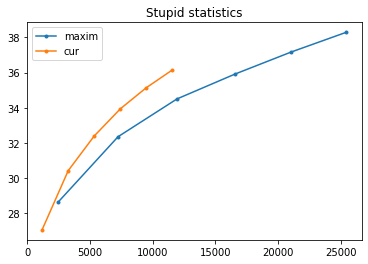

In [242]:
maxim = [[2434, 7234, 11944, 16600, 21074, 25468], [28.62, 32.35, 34.50, 35.92, 37.17, 38.29]]
my_best = [[1164, 3255, 5327, 7417, 9489, 11580],
           [27.050400047471197, 30.4208547604328, 32.38796404672407, 33.93646117870599, 35.13590137332004,
            36.151667981743785]]

plt.title('Stupid statistics')
plt.plot(maxim[0], maxim[1], marker='.', label='maxim')
plt.plot(my_best[0], my_best[1], marker='.', label='cur')
plt.legend()
plt.show()

100%|██████████| 125/125 [00:16<00:00,  7.63it/s]


[ 1164  3255  5327  7417  9489 11580] [27.050400047471197, 30.4208547604328, 32.38796404672407, 33.93646117870599, 35.13590137332004, 36.151667981743785]


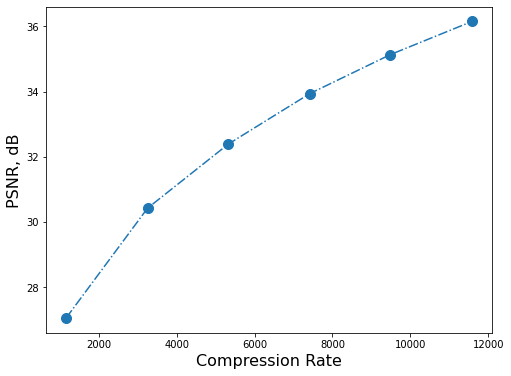

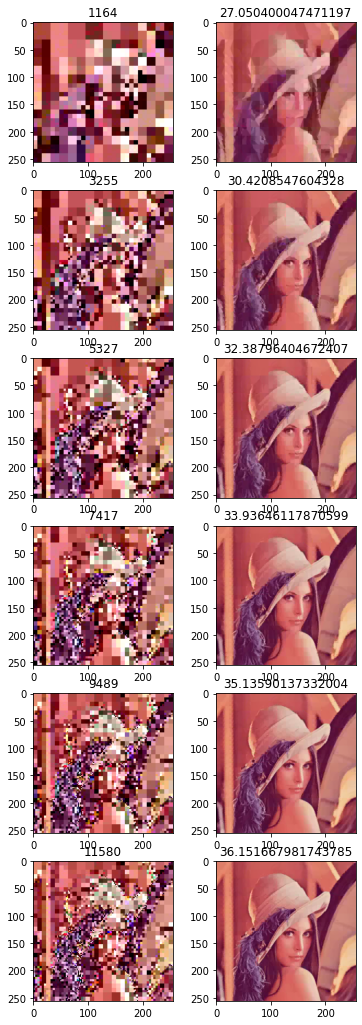

In [224]:
comp = FractalCompressor()
out27 = test_and_plot_collection([lenna_rgb_256x256])
# my best compressor for a moment. first test
# uses heap and compact form for x and y
# params: range(100, 1001, 180)

In [ ]:
comp = FractalCompressor()
out26 = test_and_plot_collection([lenna_rgb_256x256])

In [ ]:
comp = FractalCompressor()
out25 = test_and_plot_collection([lenna_rgb_256x256])

In [337]:
a = np.ones((5, 5))
b = np.ones((5, 5))
arr = np.array([a, b])
c = np.sum(arr, axis = 0)
print(c)

[[2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]]
